# Importing the required modules

In [1]:
# Modules used for data handling and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random as r
sns.set_style("whitegrid")

# Modules used for suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# Modules used for dataset split
# import splitfolders
import os

# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Model

In [2]:
# Centering all the output images in the notebook.
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Dataset Exploration

In [3]:
class Dataset:

    def __init__(self, dataset_path: str):
        self.PARENT = dataset_path
        self.class_distribution = dict()

    def __compute_class_distributions(self):
        for dirname in os.listdir(self.PARENT):
            self.class_distribution[dirname] = len(os.listdir(os.path.join(self.PARENT, dirname)))

    def class_distributions(self):
        self.__compute_class_distributions()

        plt.figure(figsize=(10,10))
        plt.bar(self.class_distribution.keys(),
                self.class_distribution.values(),
                color=["crimson","red","orange","yellow"])
        plt.xticks(rotation=90)
        plt.title("Class Distribution of PlantVillage dataset")
        plt.xlabel("Class Label")
        plt.ylabel("Frequency of class")
        plt.show()

    def show_class_samples(self):
        rows = 5
        columns = 3
        c = 0
        fig, axs = plt.subplots(rows, columns, figsize=(15,15))
        for dirname in os.listdir(self.PARENT):
            img_path = r.choice(os.listdir(os.path.join(self.PARENT, dirname)))
            image = mpimg.imread(os.path.join(self.PARENT, dirname, img_path))
            axs[c//columns, c%columns].imshow(image)
            axs[c//columns, c%columns].set_title(dirname)
            c += 1
        fig.suptitle("Image Samples of Plant Village dataset")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()


## Loading the dataset

In [4]:
# plant_village = Dataset("/kaggle/input/plant-village-dataset/PlantVillageDataset/PlantVillage/PlantVillage")

import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

100%|██████████| 658M/658M [00:06<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1


In [5]:
plant_village = Dataset("/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage/PlantVillage")

## Class Distribution

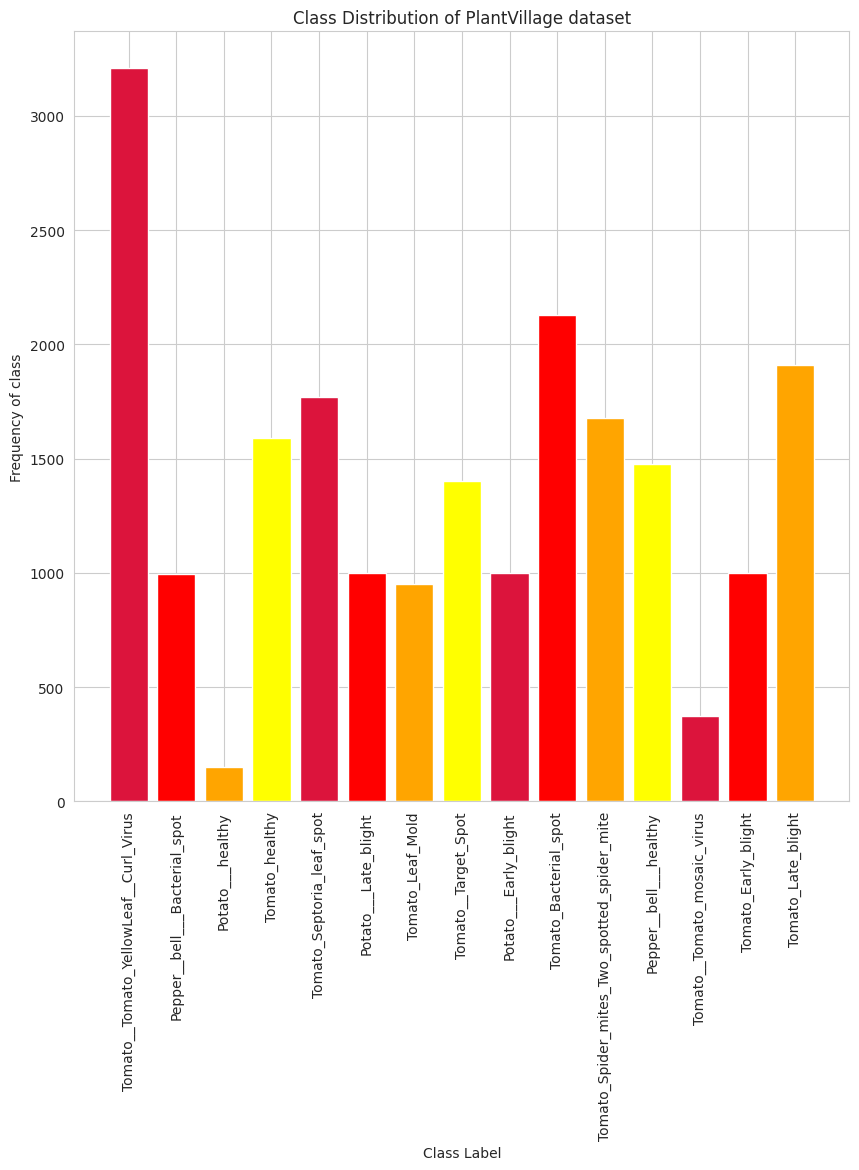

In [6]:
plant_village.class_distributions()


## Sample Images

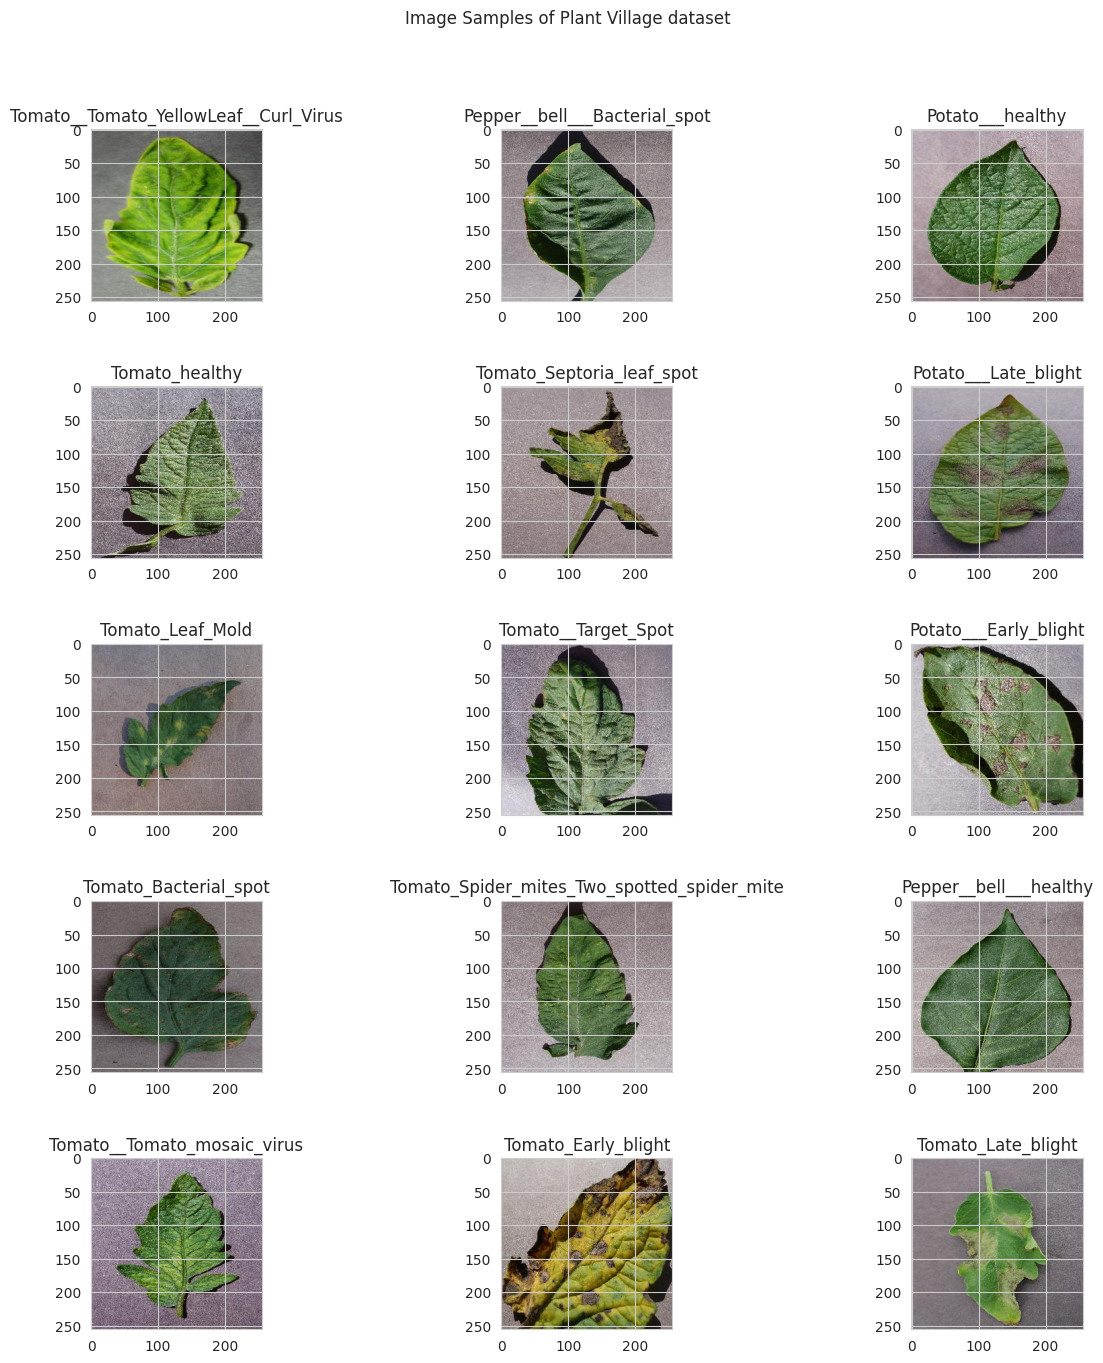

In [7]:
plant_village.show_class_samples()

# Train, Test, Validation Split

In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf

class DataSplit:

    def __init__(self, dataset_path: str, train_path: str, test_path: str, val_path: str) -> None:
        self.PARENT = dataset_path
        self.TRAIN_DIR = train_path
        self.TEST_DIR = test_path
        self.VAL_DIR = val_path
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None

    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )
        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )
        self.val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )

    def create_splits(self, dataset_path, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
        classes = os.listdir(dataset_path)
        os.makedirs(output_path, exist_ok=True)

        for split in ["train", "val", "test"]:
            os.makedirs(os.path.join(output_path, split), exist_ok=True)

        for class_name in classes:
            class_path = os.path.join(dataset_path, class_name)
            images = os.listdir(class_path)
            train, test_val = train_test_split(images, train_size=train_ratio, random_state=42)
            val, test = train_test_split(test_val, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)

            for split_name, split_data in zip(["train", "val", "test"], [train, val, test]):
                split_path = os.path.join(output_path, split_name, class_name)
                os.makedirs(split_path, exist_ok=True)
                for img in split_data:
                    shutil.copy(os.path.join(class_path, img), os.path.join(split_path, img))

    def get_images(self):
        gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
        return (
            gen.flow_from_directory(self.TRAIN_DIR, target_size=(75, 75), batch_size=32, class_mode='categorical', shuffle=True, seed=42),
            gen.flow_from_directory(self.VAL_DIR, target_size=(75, 75), batch_size=32, class_mode='categorical', shuffle=True, seed=42),
            gen.flow_from_directory(self.TEST_DIR, target_size=(75, 75), batch_size=32, class_mode='categorical', shuffle=False, seed=42)
        )

dataset_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage/PlantVillage"
output_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage/split_dataset"

train_path = output_path + "/train"
val_path = output_path + "/val"
test_path = output_path + "/test"

ds = DataSplit(dataset_path, train_path, test_path, val_path)
ds.create_splits(dataset_path, output_path)
train_images, val_images, test_images = ds.get_images()

Found 14440 images belonging to 15 classes.
Found 4128 images belonging to 15 classes.
Found 2070 images belonging to 15 classes.


In [9]:
# import shutil
# from sklearn.model_selection import train_test_split

# def create_splits(dataset_path, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
#     classes = os.listdir(dataset_path)
#     os.makedirs(output_path, exist_ok=True)

#     for split in ["train", "val", "test"]:
#         os.makedirs(os.path.join(output_path, split), exist_ok=True)

#     for class_name in classes:
#         class_path = os.path.join(dataset_path, class_name)
#         images = os.listdir(class_path)
#         train, test_val = train_test_split(images, train_size=train_ratio, random_state=42)
#         val, test = train_test_split(test_val, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)

#         for split_name, split_data in zip(["train", "val", "test"], [train, val, test]):
#             split_path = os.path.join(output_path, split_name, class_name)
#             os.makedirs(split_path, exist_ok=True)
#             for img in split_data:
#                 shutil.copy(os.path.join(class_path, img), os.path.join(split_path, img))

# dataset_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage/PlantVillage"
# output_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage/split_dataset"

# create_splits(dataset_path, output_path)


In [10]:
# ds.create_generators()
# train_images, val_images, test_images = ds.get_images()


## Train Data Insights

In [11]:
train_ds = Dataset("/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage/split_dataset/train")



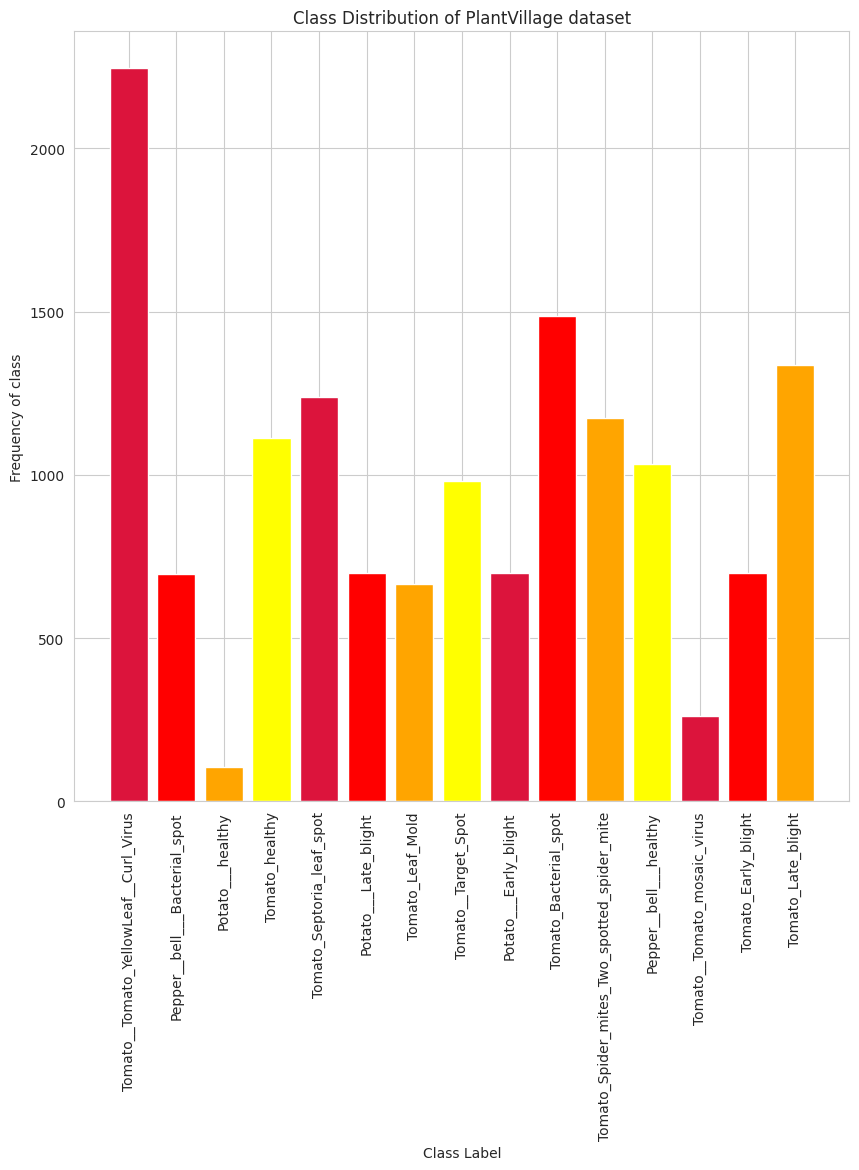

In [12]:
train_ds.class_distributions()


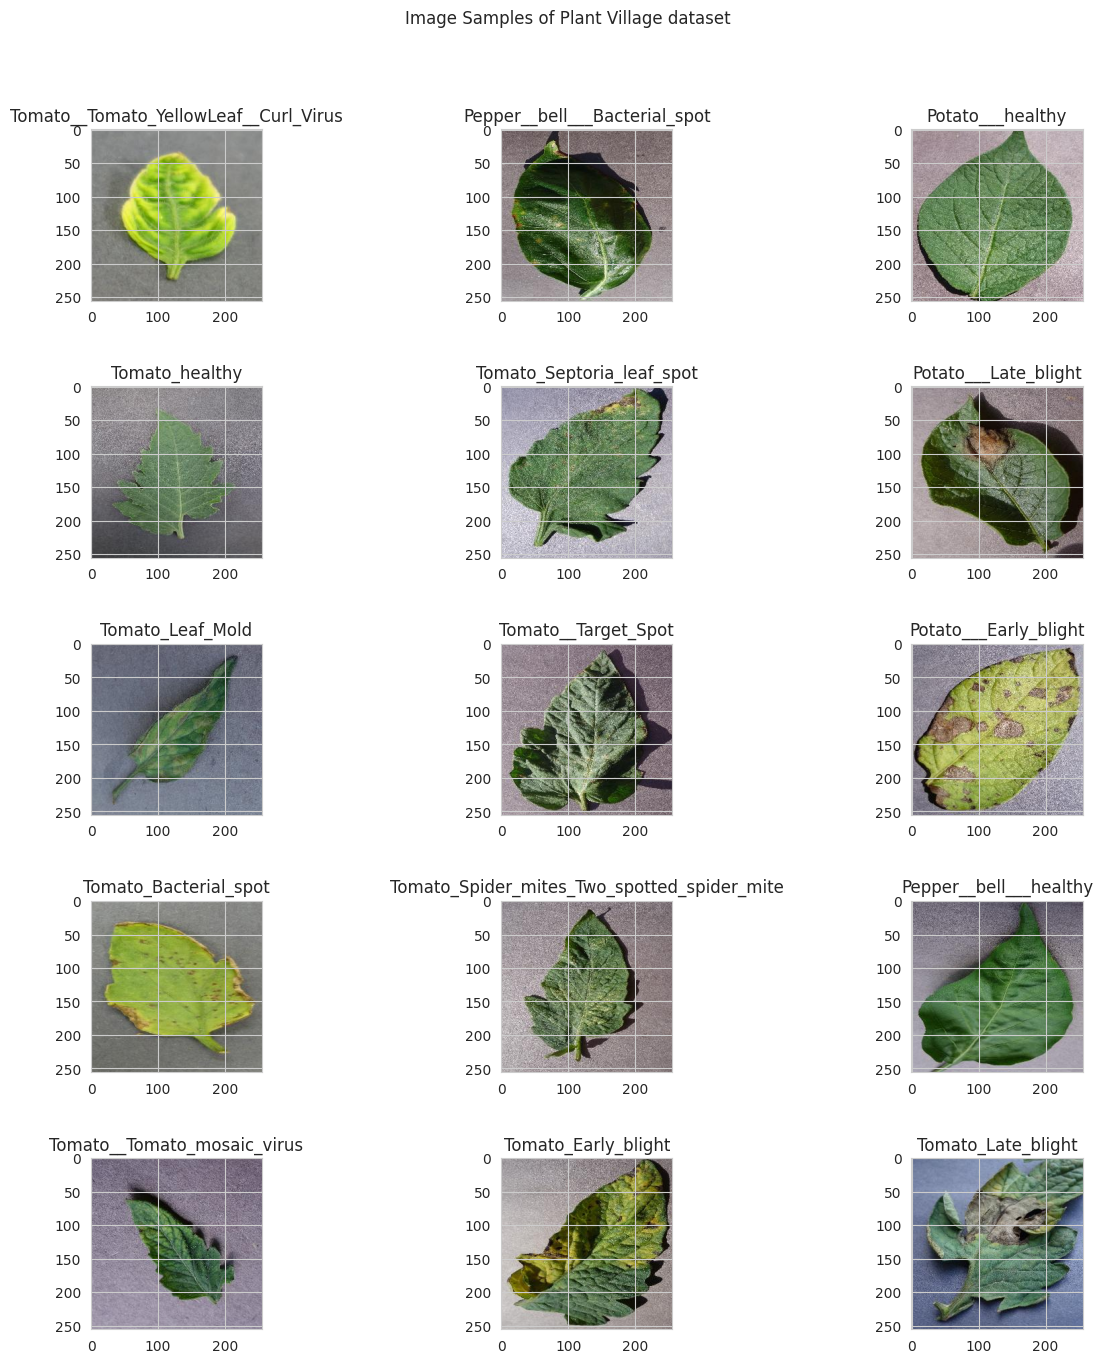

In [13]:
train_ds.show_class_samples()

## Test Data Insights

In [14]:
test = Dataset("/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage/split_dataset/test")



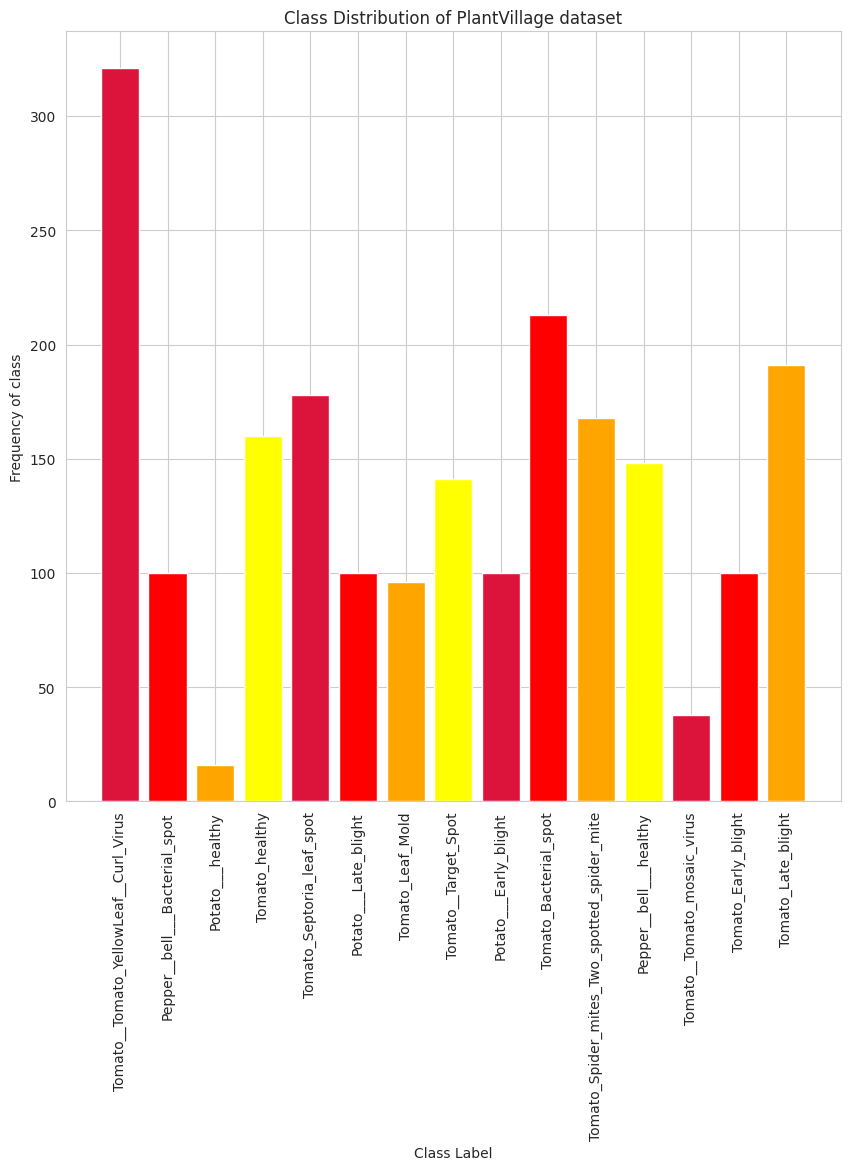

In [15]:
test.class_distributions()

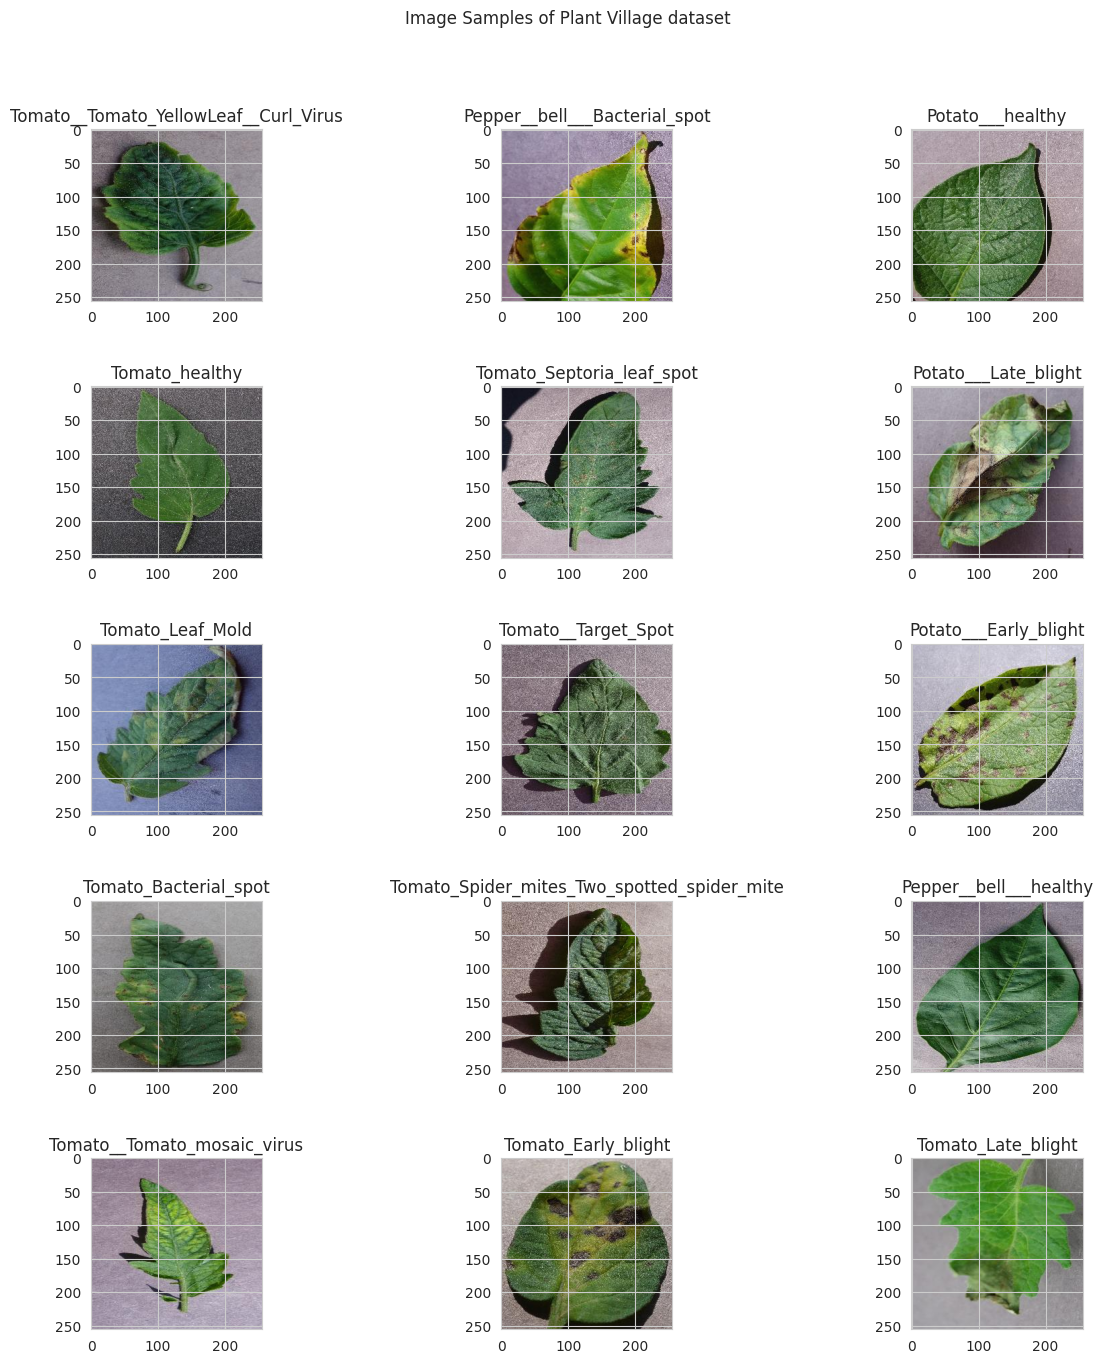

In [16]:
test.show_class_samples()

## Validation Data Insights

In [17]:
val = Dataset("/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage/split_dataset/val")

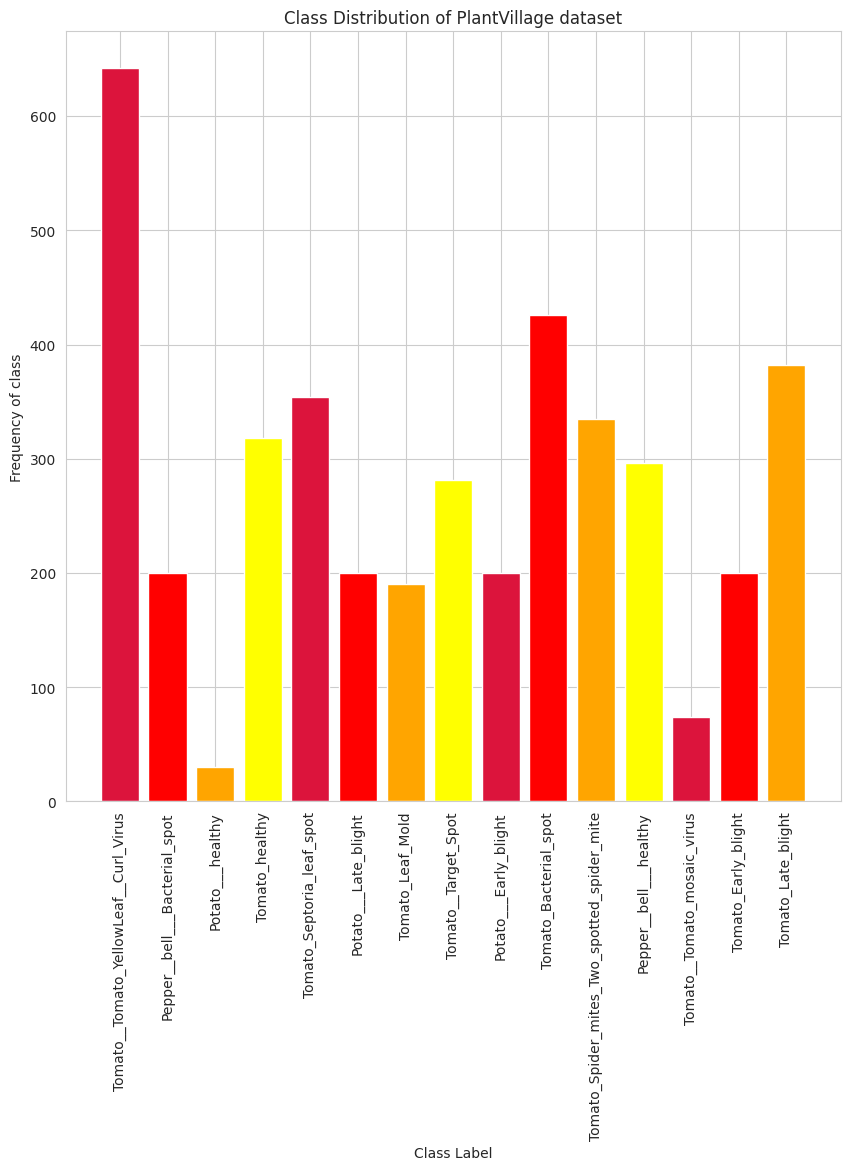

In [18]:
val.class_distributions()

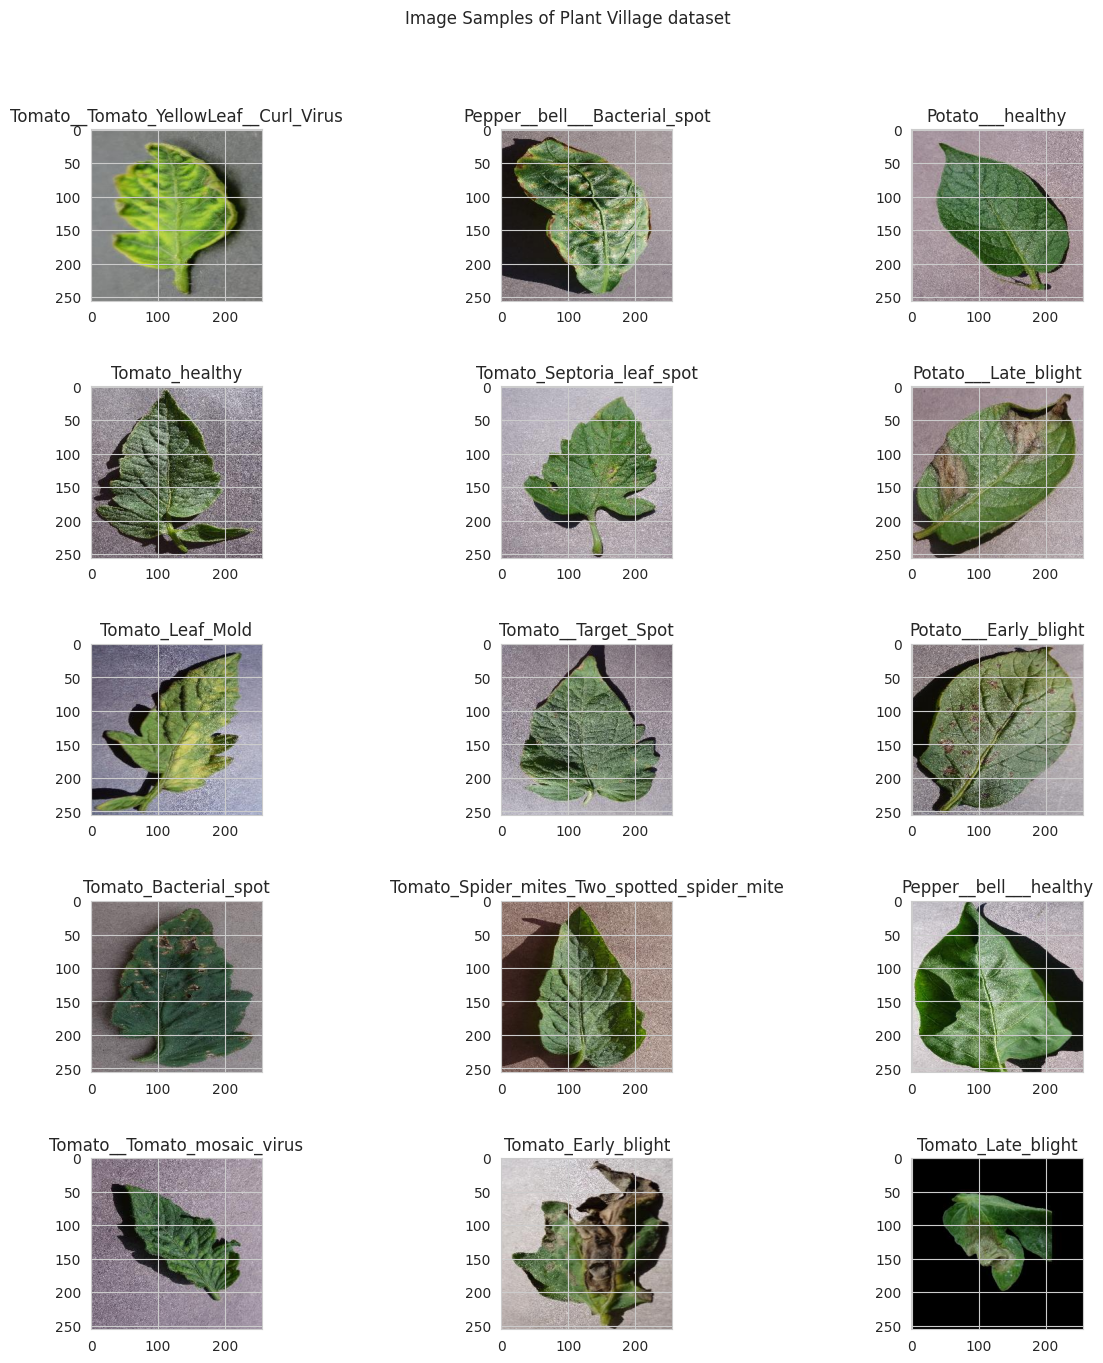

In [19]:
val.show_class_samples()

## Creating the data generators

In [20]:
dataset_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage/split_dataset"
train_path = dataset_path + "/train"
val_path = dataset_path + "/val"
test_path = dataset_path + "/test"

# Now define ds correctly
ds = DataSplit(dataset_path=dataset_path, train_path=train_path, val_path=val_path, test_path=test_path)
ds.create_generators()

train_images, val_images, test_images = ds.get_images()


Found 14440 images belonging to 15 classes.
Found 4128 images belonging to 15 classes.
Found 2070 images belonging to 15 classes.


In [21]:
train, val, test = ds.get_images()

Found 14440 images belonging to 15 classes.
Found 4128 images belonging to 15 classes.
Found 2070 images belonging to 15 classes.


# Transfer Learning

In [22]:
class TransferLearning:

    def __init__(self, train, val) -> None:
        self.train = train
        self.val = val
        self.model = None
        self.history = None

    def load_model(self):
        self.model = ResNet50(weights = 'imagenet',
                              include_top = False,
                              input_shape = (75,75,3))

    def mark_layers_non_trainable(self):
        for layer in self.model.layers:
            layer.trainable = False

    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(15, activation = 'softmax')(self.x)

    def compile_model(self):
        self.model = Model(inputs = self.model.input, outputs = self.predictions)
        self.model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

    def train_model(self):
        self.history = self.model.fit(train,
                                      batch_size=32,
                                      epochs=50, validation_data=val)

    def plot_history(self):
        fig, axs = plt.subplots(2, 1, figsize=(15,15))
        axs[0].plot(self.history.history['loss'])
        axs[0].plot(self.history.history['val_loss'])
        axs[0].title.set_text('Training Loss vs Validation Loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend(['Train','Val'])

        axs[1].plot(self.history.history['accuracy'])
        axs[1].plot(self.history.history['val_accuracy'])
        axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend(['Train', 'Val'])

## Transfer Learning using Resnet50

In [23]:
tl = TransferLearning(train=train, val=val)

## Loading the Resnet50 from Keras Application

In [24]:
tl.load_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Making all the layers of the model non-trainable

In [25]:
tl.mark_layers_non_trainable()

## Adding a final layer for classification of 15 classes

In [26]:
tl.add_final_layer()

## Compiling model

In [27]:
tl.compile_model()

## Training model

In [ ]:
tl.train_model()

Epoch 1/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 43s 66ms/step - accuracy: 0.6812 - loss: 4.2570 - val_accuracy: 0.8825 - val_loss: 0.3729
Epoch 2/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9358 - loss: 0.1817 - val_accuracy: 0.8992 - val_loss: 0.3274
Epoch 3/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9640 - loss: 0.1089 - val_accuracy: 0.8949 - val_loss: 0.3841
Epoch 4/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9613 - loss: 0.1139 - val_accuracy: 0.9009 - val_loss: 0.4135
Epoch 5/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9712 - loss: 0.0848 - val_accuracy: 0.8573 - val_loss: 0.8203
Epoch 6/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.9525 - loss: 0.1770 - val_accuracy: 0.8726 - val_loss: 0.6352
Epoch 7/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9783 - loss: 0.0680 - val_accuracy: 0.8975 - val_loss: 0.5470
Epoch 8/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9807 - loss: 0.0640 - 

In [ ]:
tl.model.save("models/first_model.h5")

In [ ]:
CLASS_NAMES = list(train.class_indices.keys())
CLASS_NAMES

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
predictions = np.argmax(tl.model.predict(test), axis=1)

In [ ]:
acc = accuracy_score(test.labels, predictions)
cm = tf.math.confusion_matrix(test.labels, predictions)
clr = classification_report(test.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(15) + 0.5, labels=CLASS_NAMES, rotation=90)
plt.yticks(ticks= np.arange(15) + 0.5, labels=CLASS_NAMES, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(clr)

## Plotting the Learning Curves

In [ ]:
tl.plot_history()

- We can observe that model achieves an accuracy of 99.73% and 93.58% on training and validation sets respectively.
- Moreover, we can also gauge that the model is overfitting slightly which can be handled by fine tuning the model using regularization and re-training the layers

# Fine-tuning

Fine Tuning is the approach in which a pretrained model is used. However, few of the layers are made trainable to understand the patterns in the current dataset. Morevoer, regularization can also be added in the form of dropout layers.

In [ ]:
class FineTuning:

    def __init__(self, train, val) -> None:
        self.train = train
        self.val = val
        self.model = None
        self.history = None
        self.fine_tune_from = 100

    def load_model(self):
        self.model = ResNet50(weights = 'imagenet',
                              include_top = False,
                              input_shape = (75,75,3))

    def fine_tune(self):
        for layer in self.model.layers[:self.fine_tune_from]:
            layer.trainable = False

        for layer in self.model.layers[self.fine_tune_from:]:
            layer.trainable = True

    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(15, activation = 'softmax')(self.x)

    def compile_model(self):
        self.model = Model(inputs = self.model.input, outputs = self.predictions)
        self.model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

    def train_model(self):
        self.history = self.model.fit(train,
                                      batch_size=32,
                                      epochs=10,
                                      validation_data=val,
                                      callbacks=[
                                        tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True
                                        )
                                     ])

    def plot_history(self):
        fig, axs = plt.subplots(2, 1, figsize=(15,15))
        axs[0].plot(self.history.history['loss'])
        axs[0].plot(self.history.history['val_loss'])
        axs[0].title.set_text('Training Loss vs Validation Loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend(['Train','Val'])

        axs[1].plot(self.history.history['accuracy'])
        axs[1].plot(self.history.history['val_accuracy'])
        axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend(['Train', 'Val'])

## Fine Tuning the ResNet50 model

In [ ]:
ft = FineTuning(train,val)

## Loading the ResNet50 model from keras applications

In [ ]:
ft.load_model()

## Making last 75 layers of the ResNet50 model trainable

In [ ]:
ft.fine_tune()

## Adding a final layer for classification of 15 classes

In [ ]:
ft.add_final_layer()

## Compiling the model

In [ ]:
ft.compile_model()

## Training the model for 5 epochs

In [ ]:
ft.train_model()

In [ ]:
ft.model.save("models/second_model.h5")

In [ ]:
predictions = np.argmax(ft.model.predict(test), axis=1)

In [ ]:
acc = accuracy_score(test.labels, predictions)
cm = tf.math.confusion_matrix(test.labels, predictions)
clr = classification_report(test.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
# plt.xticks(ticks= np.arange(15) + 0.5, labels=CLASS_NAMES, rotation=90)
# plt.yticks(ticks= np.arange(15) + 0.5, labels=CLASS_NAMES, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(clr)

## Evaluation of the fine-tuned model

In [ ]:
ft.model.evaluate(test)

## Plotting the learning curves of the fine-tuning process

In [ ]:
ft.plot_history()

# Conclusion

- Transfer Learning is approach of using a model pretrained(i.e. ResNet50) on a large dataset(here, imagenet) and using its knowledge for our case.
- As inferred earlier, transfer learning gives an accuracy of 99.73% and 93.58% on training and validation sets respectively which shows that the model is slightly overfitted resulting in the requirement of fine tuning of the model.
- The model is fine tuned by letting the last 75 layers learn the patterns in the dataset and overcome the overfitting and improve the accuracy.
- The fine tuned model gives an accuracy of 98.75%, 95.42%, and 95.56% on train, validation, and test splits.
- On a final note, in the deep learning there is required of the large overhead of time and hardware requirements for Fine Tuning of the model.

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np

# Calculate predictions for Fine-Tuning Model
predictions_ft = np.argmax(ft.model.predict(test), axis=1)

# Calculate metrics for Fine-Tuning Model
acc_ft = accuracy_score(test.labels, predictions_ft)
recall_ft = recall_score(test.labels, predictions_ft, average='weighted')
precision_ft = precision_score(test.labels, predictions_ft, average='weighted')
f1_ft = f1_score(test.labels, predictions_ft, average='weighted')

print(f"Accuracy: {acc_ft}")
print(f"Recall: {recall_ft}")
print(f"Precision: {precision_ft}")
print(f"F1 Score: {f1_ft}")
